In [1]:
import re
import urllib3
import csv
import os
import sys
import time
import datetime
import json
import operator
from pathlib import Path
import numpy as np
import pandas as pd
# from bs4 import BeautifulSoup

import nltk
from tqdm import tqdm


import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Split Dataset

后20%作为test data, 前80%中再根据4：1的比例分train和valid data

In [3]:
featureMatrix_file = Path('../Data/Features/featureMatrix.csv')
featureMatrix = pd.read_csv(featureMatrix_file, header=None, sep=" ")
length = len(featureMatrix)
train_length = 4*length//5
test_idx = slice(train_length, None)
train_idx = slice(0, 4*train_length//5)
valid_idx = slice(4*train_length//5, train_length)
train_idx, valid_idx, test_idx

(slice(0, 50216, None), slice(50216, 62771, None), slice(62771, None, None))

### Train Model


In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Bidirectional, RNN, Input, LSTM, SimpleRNN
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_crossentropy, Accuracy, mean_squared_error
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import GRU
from keras.callbacks import ModelCheckpoint
from keras import optimizers

In [33]:
df_results = pd.DataFrame()


def custom_corr(y_actual, y_pred):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    
    y_actual = (y_actual - tf.reduce_mean(y_actual))/tf.sqrt(tf.reduce_sum(tf.square(y_actual - tf.reduce_mean(y_actual))))
    y_pred = (y_pred - tf.reduce_mean(y_pred))/tf.sqrt(tf.reduce_sum(tf.square(y_pred - tf.reduce_mean(y_pred))))

    return tf.reduce_sum(y_actual*y_pred)

def corrcoef(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0][1]

Model0: Benchmark

In [14]:
featureMatrix_train = featureMatrix.loc[train_idx,:]
y_true = tf.convert_to_tensor(featureMatrix_train.iloc[:,-1].astype("float"))
y_true = tf.reshape(y_true, [-1, 1])
y_true

<tf.Tensor: shape=(50217, 1), dtype=float64, numpy=
array([[ 0.018763],
       [-0.02273 ],
       [ 0.012647],
       ...,
       [-0.020789],
       [-0.018452],
       [-0.011236]])>

In [15]:
rawret = featureMatrix_train.iloc[:,-1]
np.random.shuffle(rawret)
# rawret

In [16]:
y_pred = tf.convert_to_tensor(rawret.astype("float"))
y_pred = tf.reshape(y_pred, [-1, 1])
y_pred


<tf.Tensor: shape=(50217, 1), dtype=float64, numpy=
array([[-0.005341],
       [ 0.016286],
       [-0.005178],
       ...,
       [ 0.003065],
       [ 0.000264],
       [ 0.036136]])>

In [39]:
loss = mean_squared_error(y_true, y_pred).numpy().mean()
corr = custom_corr(y_true, y_pred).numpy()

f"mse: {loss:.4f}: corr: {corr:.4f}"

'mse: 0.0008: corr: -0.0026'

In [29]:
df_results.loc['Benchmark',["train_mse","train_corr","test_mse","test_corr"]] = [np.nan, np.nan, loss, corr]
df_results


,train_mse,train_corr,test_mse,test_corr
Benchmark,NaN,NaN,0.000846,-0.002578



Model1:  CNN

In [35]:
model_name = "CNN"
model_directory = Path(f'../Data/Model/{model_name}')
model_directory.mkdir(exist_ok=True)


def CNN():
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=3, strides=(1, 3),
              padding='valid', input_shape=(60, 25, 1), activation='swish'))
    model.add(Convolution2D(filters=32, kernel_size=3, strides=(5, 3),
                            padding='valid', activation='swish'))
    model.add(MaxPooling2D(pool_size=(5, 1)))
    model.add(Flatten())
    # model.add(Dense(256, activation='swish'))
    # model.add(BatchNormalization(axis=-1))
    # model.add(Dropout(0.2))
    model.add(Dense(128, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='huber',
                  optimizer=adam, metrics=['mse',custom_corr])
    return model


model = CNN()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 58, 8, 32)         320       
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 2, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                      

In [36]:
def My_Generator(fileName,batch_size):
    chunksize = batch_size
    while True:
        for chunk in pd.read_csv(fileName, chunksize=chunksize,sep=" "):
            batchFeatures = np.array(chunk.iloc[:,:-1])
            batchFeatures = np.reshape(batchFeatures,(batchFeatures.shape[0],25,60)).transpose(0,2,1)
            batchFeatures = batchFeatures[:,:,:,np.newaxis]
            batchLabels = np.matrix(chunk.iloc[:,-1]).T
            # batchLabels = 
            batchLabels= np.matrix(batchLabels)
            yield batchFeatures,batchLabels

training_filenames = Path('../Data/Features/featureMatrix_train.csv')
my_training_batch_generator = My_Generator(training_filenames, 10)
feature_batch, target_batch = next(my_training_batch_generator)

feature_batch_shape = feature_batch.shape[1]
feature_batch.shape, target_batch.shape

((10, 60, 25, 1), (10, 1))

In [37]:
batch_size = 512
training_filenames = Path('../Data/Features/featureMatrix_train.csv')
validation_filenames = Path('../Data/Features/featureMatrix_valid.csv')
test_filenames = Path('../Data/Features/featureMatrix_test.csv')
num_training_samples = train_length*4//5
num_validation_samples = train_length//5
num_test_samples = length - train_length


# Training and Validation Set Loader
my_training_batch_generator = My_Generator(training_filenames, batch_size)
my_validation_batch_generator = My_Generator(validation_filenames, batch_size)
my_test_batch_generator = My_Generator(test_filenames, batch_size)
my_test_batch_generator_one = My_Generator(test_filenames, batch_size)

print(my_training_batch_generator)


checkpoint_cb = ModelCheckpoint(
    model_directory, monitor="val_custom_corr", mode="max", save_best_only=True, save_weights_only=True)


modelHistory = model.fit_generator(generator=my_training_batch_generator,
                                   steps_per_epoch=(
                                       int(np.ceil(num_training_samples / (batch_size)))),
                                   epochs=15,
                                   verbose=1,
                                   validation_data=my_validation_batch_generator,
                                   validation_steps=(
                                       int(np.ceil(num_validation_samples // (batch_size)))),
                                   max_queue_size=32,
                                   callbacks=[checkpoint_cb]
                                   )


<generator object My_Generator at 0x0000027C0FEE5270>
Epoch 1/15
99/99 [==============================] - 12s 112ms/step - loss: 0.1699 - mse: 0.3839 - custom_corr: -0.0064 - val_loss: 4.6711e-04 - val_mse: 9.3423e-04 - val_custom_corr: -1.1623e-04
Epoch 2/15
99/99 [==============================] - 11s 117ms/step - loss: 0.0795 - mse: 0.1714 - custom_corr: -0.0026 - val_loss: 7.1251e-04 - val_mse: 0.0014 - val_custom_corr: -9.5724e-04
Epoch 3/15
99/99 [==============================] - 10s 100ms/step - loss: 0.0516 - mse: 0.1170 - custom_corr: -0.0029 - val_loss: 0.0012 - val_mse: 0.0025 - val_custom_corr: -0.0029
Epoch 4/15
99/99 [==============================] - 10s 97ms/step - loss: 0.0358 - mse: 0.0841 - custom_corr: 0.0070 - val_loss: 0.0015 - val_mse: 0.0030 - val_custom_corr: -0.0021
Epoch 5/15
99/99 [==============================] - 9s 96ms/step - loss: 0.0266 - mse: 0.0629 - custom_corr: 0.0079 - val_loss: 0.0011 - val_mse: 0.0023 - val_custom_corr: -0.0019
Epoch 6/15
99/99

31/31 [==============================] - 2s 78ms/step - loss: 3.4365e-04 - mse: 6.8731e-04 - custom_corr: 0.0073
test_loss: 0.0003: test_acc: 0.0007


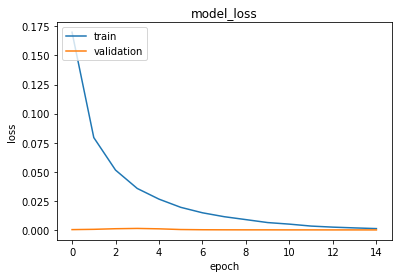

In [38]:
model.load_weights(model_directory)
conf = model.evaluate_generator(my_test_batch_generator, steps=(int(np.ceil(num_test_samples/ (batch_size)))),
                            use_multiprocessing=False, verbose=1)
# print(conf)
print(f"test_loss: {conf[0]:.4f}: test_corr: {conf[1]:.4f}")
# conf = model.predict_generator(my_test_batch_generator_one, steps=(int(np.ceil(num_test_samples/ (batch_size)))), use_multiprocessing=False, verbose=1)
# print(conf)

# model_json = model.to_json()
# with open("./input/model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("./input/model.h5")
# print("Saved model to disk")

# print(modelHistory.history.keys())
plt.plot(modelHistory.history['loss'])
plt.plot(modelHistory.history['val_loss'])
plt.title('model_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper left')
plt.show()


In [226]:
df_results.loc['CNN', ["train_loss","train_acc","test_loss","test_acc"]] = [0.7298, 0.5086, 0.7235, 0.5103]
df_results

,train_loss,train_acc,test_loss,test_acc
Benchmark,NaN,NaN,8.045407,0.500846
CNN,0.7298,0.5086,0.723500,0.510300



Model2:  SimpleRNN

In [240]:
model_name = "sRNN"
model_directory = Path(f'../Data/Model/{model_name}')
model_directory.mkdir(exist_ok=True)

def sRNN():
    model = Sequential()
    # model.add(Input(shape=(None, 60, 25)))
    model.add(SimpleRNN(128, return_sequences=True, input_shape=(60, 25)))
    # model.add(LSTM(64, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    # model.add(BatchNormalization(axis=-1))
    # model.add(LSTM(128,return_sequences=True,activation='relu'))
    # model.add(BatchNormalization(axis=-1))
    model.add(Flatten())
    model.add(Dense(128, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam, metrics=['acc'])
    return model


model = sRNN()
model.summary()


Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 60, 128)           19712     
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 60, 32)            5152      
                                                                 
 flatten_55 (Flatten)        (None, 1920)              0         
                                                                 
 dense_219 (Dense)           (None, 128)               245888    
                                                                 
 batch_normalization_174 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout_165 (Dropout)       (None, 128)               0         
                                                     

In [241]:
def My_Generator(fileName,batch_size):
    chunksize = batch_size
    while True:
        for chunk in pd.read_csv(fileName, chunksize=chunksize,sep=" "):
            batchFeatures = np.array(chunk.iloc[:,:-1])
            batchFeatures = np.reshape(batchFeatures,(batchFeatures.shape[0],25,60)).transpose(0,2,1)
            # batchFeatures = batchFeatures[:,:,:,np.newaxis]
            batchLabels = np.matrix(chunk.iloc[:,-1]).T
            batchLabels = to_categorical(value2int_simple(batchLabels),num_classes=2).astype("int")
            batchLabels= np.matrix(batchLabels)
            yield batchFeatures,batchLabels

training_filenames = Path('../Data/Features/featureMatrix_train.csv')
my_training_batch_generator = My_Generator(training_filenames, 10)
feature_batch, target_batch = next(my_training_batch_generator)

feature_batch_shape = feature_batch.shape[1]
feature_batch.shape, target_batch.shape

((10, 60, 25), (10, 2))

In [242]:
batch_size = 512
training_filenames = Path('../Data/Features/featureMatrix_train.csv')
validation_filenames = Path('../Data/Features/featureMatrix_valid.csv')
test_filenames = Path('../Data/Features/featureMatrix_test.csv')
num_training_samples = train_length*4//5
num_validation_samples = train_length//5
num_test_samples = length - train_length


# Training and Validation Set Loader
my_training_batch_generator = My_Generator(training_filenames, batch_size)
my_validation_batch_generator = My_Generator(validation_filenames, batch_size)
my_test_batch_generator = My_Generator(test_filenames, batch_size)
my_test_batch_generator_one = My_Generator(test_filenames, batch_size)

print(my_training_batch_generator)

checkpoint_cb = ModelCheckpoint(
    model_directory, monitor="val_acc", mode="max", save_best_only=True, save_weights_only=True)


modelHistory = model.fit_generator(generator=my_training_batch_generator,
                                   steps_per_epoch=(
                                       int(np.ceil(num_training_samples / (batch_size)))),
                                   epochs=15,
                                   verbose=1,
                                   validation_data=my_validation_batch_generator,
                                   validation_steps=(
                                       int(np.ceil(num_validation_samples // (batch_size)))),
                                   max_queue_size=32,
                                   callbacks=[checkpoint_cb]
                                   )


<generator object My_Generator at 0x00000153D4D21580>
Epoch 1/15
99/99 [==============================] - 13s 122ms/step - loss: 0.7418 - acc: 0.5041 - val_loss: 0.6957 - val_acc: 0.4945
Epoch 2/15
99/99 [==============================] - 13s 135ms/step - loss: 0.7153 - acc: 0.5006 - val_loss: 0.6954 - val_acc: 0.5053
Epoch 3/15
99/99 [==============================] - 12s 124ms/step - loss: 0.7083 - acc: 0.5038 - val_loss: 0.6943 - val_acc: 0.4941
Epoch 4/15
99/99 [==============================] - 12s 125ms/step - loss: 0.7056 - acc: 0.5056 - val_loss: 0.6949 - val_acc: 0.5010
Epoch 5/15
99/99 [==============================] - 12s 117ms/step - loss: 0.7027 - acc: 0.5069 - val_loss: 0.6946 - val_acc: 0.4937
Epoch 6/15
99/99 [==============================] - 13s 133ms/step - loss: 0.7003 - acc: 0.5148 - val_loss: 0.6949 - val_acc: 0.4967
Epoch 7/15
99/99 [==============================] - 12s 118ms/step - loss: 0.6950 - acc: 0.5332 - val_loss: 0.6953 - val_acc: 0.4928
Epoch 8/15
99/9

31/31 [==============================] - 3s 85ms/step - loss: 0.8396 - acc: 0.5052
test_loss: 0.8396: test_acc: 0.5052


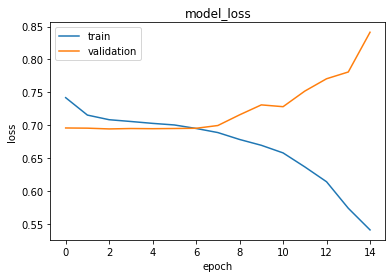

In [244]:

conf = model.evaluate_generator(my_test_batch_generator, steps=(int(np.ceil(num_test_samples/ (batch_size)))),
                            use_multiprocessing=False, verbose=1)
# print(conf)
print(f"test_loss: {conf[0]:.4f}: test_acc: {conf[1]:.4f}")
# conf = model.predict_generator(my_test_batch_generator_one, steps=(int(np.ceil(num_test_samples/ (batch_size)))), use_multiprocessing=False, verbose=1)
# print(conf)

# model_json = model.to_json()
# with open("./input/model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("./input/model.h5")
# print("Saved model to disk")

# print(modelHistory.history.keys())
plt.plot(modelHistory.history['loss'])
plt.plot(modelHistory.history['val_loss'])
plt.title('model_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper left')
plt.show()



In [245]:
df_results.loc['simpleRNN', ["train_loss","train_acc","test_loss","test_acc"]] = [0.7809, 0.5128, 0.8396, 0.5052]
df_results

,train_loss,train_acc,test_loss,test_acc
Benchmark,NaN,NaN,8.045407,0.500846
CNN,0.7298,0.5086,0.723500,0.510300
simpleRNN,0.7809,0.5128,0.839600,0.505200
simpleLSTM,0.7123,0.5108,0.712900,0.503500



Model3:  SimpleLSTM

In [228]:
model_name = "SimpleLSTM"
model_directory = Path(f'../Data/Model/{model_name}')
model_directory.mkdir(exist_ok=True)

def SimpleLSTM():
    model = Sequential()
    # model.add(Input(shape=(None, 60, 25)))
    model.add(LSTM(64, return_sequences=True, input_shape=(60, 25)))
    # model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    # model.add(BatchNormalization(axis=-1))
    # model.add(LSTM(128,return_sequences=True,activation='relu'))
    # model.add(BatchNormalization(axis=-1))
    model.add(Flatten())
    model.add(Dense(128, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam, metrics=['acc'])
    return model


model = SimpleLSTM()
model.summary()


Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 60, 64)            23040     
                                                                 
 lstm_29 (LSTM)              (None, 60, 64)            33024     
                                                                 
 flatten_53 (Flatten)        (None, 3840)              0         
                                                                 
 dense_211 (Dense)           (None, 128)               491648    
                                                                 
 batch_normalization_168 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout_159 (Dropout)       (None, 128)               0         
                                                     

In [229]:
def My_Generator(fileName,batch_size):
    chunksize = batch_size
    while True:
        for chunk in pd.read_csv(fileName, chunksize=chunksize,sep=" "):
            batchFeatures = np.array(chunk.iloc[:,:-1])
            batchFeatures = np.reshape(batchFeatures,(batchFeatures.shape[0],25,60)).transpose(0,2,1)
            # batchFeatures = batchFeatures[:,:,:,np.newaxis]
            batchLabels = np.matrix(chunk.iloc[:,-1]).T
            batchLabels = to_categorical(value2int_simple(batchLabels),num_classes=2).astype("int")
            batchLabels= np.matrix(batchLabels)
            yield batchFeatures,batchLabels

training_filenames = Path('../Data/Features/featureMatrix_train.csv')
my_training_batch_generator = My_Generator(training_filenames, 10)
feature_batch, target_batch = next(my_training_batch_generator)

feature_batch_shape = feature_batch.shape[1]
feature_batch.shape, target_batch.shape

((10, 60, 25), (10, 2))

In [230]:
batch_size = 512
training_filenames = Path('../Data/Features/featureMatrix_train.csv')
validation_filenames = Path('../Data/Features/featureMatrix_valid.csv')
test_filenames = Path('../Data/Features/featureMatrix_test.csv')
num_training_samples = train_length*4//5
num_validation_samples = train_length//5
num_test_samples = length - train_length


# Training and Validation Set Loader
my_training_batch_generator = My_Generator(training_filenames, batch_size)
my_validation_batch_generator = My_Generator(validation_filenames, batch_size)
my_test_batch_generator = My_Generator(test_filenames, batch_size)
my_test_batch_generator_one = My_Generator(test_filenames, batch_size)

print(my_training_batch_generator)

checkpoint_cb = ModelCheckpoint(
    model_directory, monitor="val_acc", mode="max", save_best_only=True, save_weights_only=True)


modelHistory = model.fit_generator(generator=my_training_batch_generator,
                                   steps_per_epoch=(
                                       int(np.ceil(num_training_samples / (batch_size)))),
                                   epochs=15,
                                   verbose=1,
                                   validation_data=my_validation_batch_generator,
                                   validation_steps=(
                                       int(np.ceil(num_validation_samples // (batch_size)))),
                                   max_queue_size=32,
                                   callbacks=[checkpoint_cb]
                                   )


<generator object My_Generator at 0x000001536D858820>
Epoch 1/15
99/99 [==============================] - 13s 116ms/step - loss: 0.7571 - acc: 0.5022 - val_loss: 0.7027 - val_acc: 0.5005
Epoch 2/15
99/99 [==============================] - 11s 109ms/step - loss: 0.7209 - acc: 0.5059 - val_loss: 0.6949 - val_acc: 0.5014
Epoch 3/15
99/99 [==============================] - 11s 113ms/step - loss: 0.7120 - acc: 0.5084 - val_loss: 0.6968 - val_acc: 0.5048
Epoch 4/15
99/99 [==============================] - 11s 109ms/step - loss: 0.7069 - acc: 0.5130 - val_loss: 0.6957 - val_acc: 0.5015
Epoch 5/15
99/99 [==============================] - 11s 110ms/step - loss: 0.7033 - acc: 0.5169 - val_loss: 0.6974 - val_acc: 0.5000
Epoch 6/15
99/99 [==============================] - 11s 109ms/step - loss: 0.6989 - acc: 0.5206 - val_loss: 0.6967 - val_acc: 0.4996
Epoch 7/15
99/99 [==============================] - 11s 112ms/step - loss: 0.6957 - acc: 0.5306 - val_loss: 0.6966 - val_acc: 0.4945
Epoch 8/15
99/9

31/31 [==============================] - 3s 85ms/step - loss: 0.7129 - acc: 0.5035
test_loss: 0.7129: test_acc: 0.5035


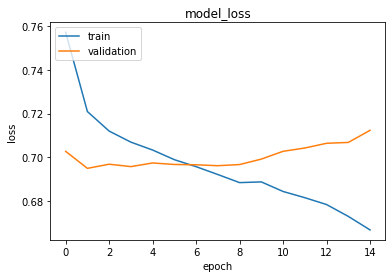

In [231]:

conf = model.evaluate_generator(my_test_batch_generator, steps=(int(np.ceil(num_test_samples/ (batch_size)))),
                            use_multiprocessing=False, verbose=1)
# print(conf)
print(f"test_loss: {conf[0]:.4f}: test_acc: {conf[1]:.4f}")
# conf = model.predict_generator(my_test_batch_generator_one, steps=(int(np.ceil(num_test_samples/ (batch_size)))), use_multiprocessing=False, verbose=1)
# print(conf)

# model_json = model.to_json()
# with open("./input/model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("./input/model.h5")
# print("Saved model to disk")

# print(modelHistory.history.keys())
plt.plot(modelHistory.history['loss'])
plt.plot(modelHistory.history['val_loss'])
plt.title('model_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper left')
plt.show()



In [232]:
df_results.loc['simpleLSTM', ["train_loss","train_acc","test_loss","test_acc"]] = [0.7123 , 0.5108, 0.7129, 0.5035]
df_results

,train_loss,train_acc,test_loss,test_acc
Benchmark,NaN,NaN,8.045407,0.500846
CNN,0.7298,0.5086,0.723500,0.510300
simpleRNN,1.0097,0.5096,1.097200,0.507300
simpleLSTM,0.7123,0.5108,0.712900,0.503500



Model4:  BiGRU

In [246]:
model_name = "BiGRU"
model_directory = Path(f'../Data/Model/{model_name}/')
model_directory.mkdir(exist_ok=True)


def BiGRU():
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences=True, kernel_regularizer='l2'),
              input_shape=(60, 25), merge_mode='ave'))
    model.add(Bidirectional(GRU(64, return_sequences=True,
               kernel_regularizer='l2'), merge_mode='ave'))
    model.add(BatchNormalization(axis=-1))
    # model.add(LSTM(128,return_sequences=True,activation='relu'))
    # model.add(BatchNormalization(axis=-1))
    model.add(Flatten())
    model.add(Dense(128, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='swish'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam, metrics=['acc'])
    return model


model = BiGRU()
model.summary()


Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirecti  (None, 60, 128)          119040    
 onal)                                                           
                                                                 
 bidirectional_21 (Bidirecti  (None, 60, 64)           74496     
 onal)                                                           
                                                                 
 batch_normalization_177 (Ba  (None, 60, 64)           256       
 tchNormalization)                                               
                                                                 
 flatten_56 (Flatten)        (None, 3840)              0         
                                                                 
 dense_223 (Dense)           (None, 128)               491648    
                                                     

In [247]:
def My_Generator(fileName,batch_size):
    chunksize = batch_size
    while True:
        for chunk in pd.read_csv(fileName, chunksize=chunksize,sep=" "):
            batchFeatures = np.array(chunk.iloc[:,:-1])
            batchFeatures = np.reshape(batchFeatures,(batchFeatures.shape[0],25,60)).transpose(0,2,1)
            # batchFeatures = batchFeatures[:,:,:,np.newaxis]
            batchLabels = np.matrix(chunk.iloc[:,-1]).T
            batchLabels = to_categorical(value2int_simple(batchLabels),num_classes=2).astype("int")
            batchLabels= np.matrix(batchLabels)
            yield batchFeatures,batchLabels

training_filenames = Path('../Data/Features/featureMatrix_train.csv')
my_training_batch_generator = My_Generator(training_filenames, 10)
feature_batch, target_batch = next(my_training_batch_generator)

feature_batch_shape = feature_batch.shape[1]
feature_batch.shape, target_batch.shape

((10, 60, 25), (10, 2))

In [248]:
batch_size = 512
training_filenames = Path('../Data/Features/featureMatrix_train.csv')
validation_filenames = Path('../Data/Features/featureMatrix_valid.csv')
test_filenames = Path('../Data/Features/featureMatrix_test.csv')
num_training_samples = train_length*4//5
num_validation_samples = train_length//5
num_test_samples = length - train_length


# Training and Validation Set Loader
my_training_batch_generator = My_Generator(training_filenames, batch_size)
my_validation_batch_generator = My_Generator(validation_filenames, batch_size)
my_test_batch_generator = My_Generator(test_filenames, batch_size)
my_test_batch_generator_one = My_Generator(test_filenames, batch_size)

print(my_training_batch_generator)

checkpoint_cb = ModelCheckpoint(
    model_directory, monitor="val_acc", mode="max", save_best_only=True, save_weights_only=True)


modelHistory = model.fit_generator(generator=my_training_batch_generator,
                                   steps_per_epoch=(
                                       int(np.ceil(num_training_samples / (batch_size)))),
                                   epochs=15,
                                   verbose=1,
                                   validation_data=my_validation_batch_generator,
                                   validation_steps=(
                                       int(np.ceil(num_validation_samples // (batch_size)))),
                                   max_queue_size=32,
                                   callbacks=[checkpoint_cb]
                                   )


<generator object My_Generator at 0x00000153C8613190>
Epoch 1/15
99/99 [==============================] - 16s 125ms/step - loss: 2.4929 - acc: 0.5004 - val_loss: 1.1414 - val_acc: 0.5039
Epoch 2/15
99/99 [==============================] - 11s 110ms/step - loss: 0.8845 - acc: 0.5037 - val_loss: 0.7323 - val_acc: 0.5058
Epoch 3/15
99/99 [==============================] - 11s 112ms/step - loss: 0.7277 - acc: 0.5003 - val_loss: 0.7005 - val_acc: 0.4950
Epoch 4/15
99/99 [==============================] - 11s 111ms/step - loss: 0.7094 - acc: 0.4997 - val_loss: 0.6955 - val_acc: 0.4951
Epoch 5/15
99/99 [==============================] - 12s 117ms/step - loss: 0.7043 - acc: 0.5051 - val_loss: 0.6975 - val_acc: 0.4950
Epoch 6/15
99/99 [==============================] - 11s 113ms/step - loss: 0.7012 - acc: 0.5056 - val_loss: 0.6952 - val_acc: 0.5055
Epoch 7/15
99/99 [==============================] - 11s 110ms/step - loss: 0.7005 - acc: 0.5019 - val_loss: 0.7236 - val_acc: 0.4950
Epoch 8/15
99/9

31/31 [==============================] - 3s 80ms/step - loss: 0.7008 - acc: 0.5153
test_loss: 0.7008: test_acc: 0.5153


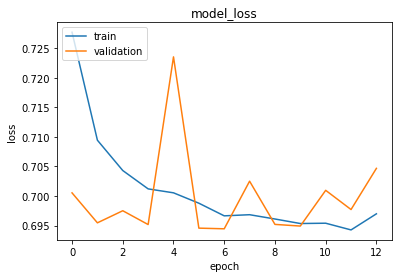

In [250]:

conf = model.evaluate_generator(my_test_batch_generator, steps=(int(np.ceil(num_test_samples/ (batch_size)))),
                            use_multiprocessing=False, verbose=1)
# print(conf)
print(f"test_loss: {conf[0]:.4f}: test_acc: {conf[1]:.4f}")
# conf = model.predict_generator(my_test_batch_generator_one, steps=(int(np.ceil(num_test_samples/ (batch_size)))), use_multiprocessing=False, verbose=1)
# print(conf)

# model_json = model.to_json()
# with open("./input/model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("./input/model.h5")
# print("Saved model to disk")

# print(modelHistory.history.keys())
plt.plot(modelHistory.history['loss'][2:])
plt.plot(modelHistory.history['val_loss'][2:])
plt.title('model_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper left')
plt.show()


In [251]:
df_results.loc['BiGRU', ["train_loss","train_acc","test_loss","test_acc"]] = [0.6983, 0.5058, 0.7008, 0.5153]
df_results

,train_loss,train_acc,test_loss,test_acc
Benchmark,NaN,NaN,8.045407,0.500846
CNN,0.7298,0.5086,0.723500,0.510300
simpleRNN,0.7809,0.5128,0.839600,0.505200
simpleLSTM,0.7123,0.5108,0.712900,0.503500
BiGRU,0.6983,0.5058,0.700800,0.515300
